In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from geopy import distance
from fuzzywuzzy import fuzz, process
from shapely.geometry import Point, Polygon

In [2]:
%matplotlib inline

In [3]:
mta = pd.read_csv('mta_2022.csv')
stations = pd.read_csv('stations.csv')

In [4]:
mta.head()

,Unnamed: 0,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,0,A002,R051,02-00-00,59 ST,NQR456W,BMT,02/26/2022,03:00:00,REGULAR,7689737,2671257
1,1,A002,R051,02-00-00,59 ST,NQR456W,BMT,02/26/2022,07:00:00,REGULAR,7689741,2671278
2,2,A002,R051,02-00-00,59 ST,NQR456W,BMT,02/26/2022,11:00:00,REGULAR,7689758,2671380
3,3,A002,R051,02-00-00,59 ST,NQR456W,BMT,02/26/2022,15:00:00,REGULAR,7689791,2671465
4,4,A002,R051,02-00-00,59 ST,NQR456W,BMT,02/26/2022,19:00:00,REGULAR,7689858,2671530


In [5]:
stations.head()

,Unnamed: 0,Station ID,Complex ID,GTFS Stop ID,Division,Line,Stop Name,Borough,Daytime Routes,Structure,GTFS Latitude,GTFS Longitude,North Direction Label,South Direction Label,ADA,ADA Direction Notes,ADA NB,ADA SB,Capital Outage NB,Capital Outage SB
0,0,1,1,R01,BMT,Astoria,Astoria-Ditmars Blvd,Q,N W,Elevated,40.775036,-73.912034,NaN,Manhattan,0,NaN,NaN,NaN,NaN,NaN
1,1,2,2,R03,BMT,Astoria,Astoria Blvd,Q,N W,Elevated,40.770258,-73.917843,Ditmars Blvd,Manhattan,1,NaN,NaN,NaN,NaN,NaN
2,2,3,3,R04,BMT,Astoria,30 Av,Q,N W,Elevated,40.766779,-73.921479,Astoria - Ditmars Blvd,Manhattan,0,NaN,NaN,NaN,NaN,NaN
3,3,4,4,R05,BMT,Astoria,Broadway,Q,N W,Elevated,40.761820,-73.925508,Astoria - Ditmars Blvd,Manhattan,0,NaN,NaN,NaN,NaN,NaN
4,4,5,5,R06,BMT,Astoria,36 Av,Q,N W,Elevated,40.756804,-73.929575,Astoria - Ditmars Blvd,Manhattan,0,NaN,NaN,NaN,NaN,NaN


In [6]:
columns_dict_mta = {
    'STATION': 'Station',
    'ENTRIES': 'Cumulative Entries',
    'EXITS': 'Cumulative Exits'
}

columns_dict_station = {
    'Stop Name' : 'Station',
    'GTFS Latitude' : 'Latitude',
    'GTFS Longitude' : 'Longitude'
}

stations_borough_dict = {
    'Q': 'Queens',
    'M': 'Manhattan',
    'Bk': 'Brooklyn',
    'Bx': 'The Bronx',
    'SI': 'Staten Island'
}

In [7]:
mta['DESC'].value_counts(normalize = True)
# As it can be seen here, using only REGULAR counts will not affect our analysis considering RECOVR AUD counts contains
# so much problematic data..

REGULAR       0.995641
RECOVR AUD    0.004359
Name: DESC, dtype: float64

In [8]:
# SCP is a single unit of a turnstile.
# C/A is a control area which is combination of multiple turnstiles in a particular entrance of the station.
# UNIT is a remote unit id for each station
# I will combine those to have a Unique ID for each turnstile.

In [9]:
def time_period(x):
    if (x>0) & (x<=4):
        return '12am - 4am'
    elif (x>4) & (x<=8):
        return '4am - 8am'
    elif (x>8) & (x<=12):
        return '8am - 12pm'
    elif (x>12) & (x<=16):
        return '12pm - 4pm'
    elif (x>16) & (x<=20):
        return '4pm - 8pm'
    elif (x>20) & (x<24) | (x==0) :
        return '8pm - 12am'

In [10]:
mta = mta[mta['DESC'] == 'REGULAR']
mta['Unique ID'] = mta['C/A'] + '-' + mta['UNIT'] + '-' + mta['SCP']

mta['Datetime'] = mta['DATE'] + ' ' + mta['TIME']
mta['Datetime'] = pd.to_datetime(mta['Datetime'])

mta['Hour'] = mta['Datetime'].dt.hour
mta['Day'] = mta['Datetime'].dt.day_name()
mta['Month'] = mta['Datetime'].dt.month_name()
mta['Date'] = mta['Datetime'].dt.date
mta['Time Period'] = mta['Hour'].apply(lambda x: time_period(x))

mta.rename(columns = lambda x: x.strip(), inplace = True)
mta = mta[mta['Datetime'] >= '2022-03-01']
mta.reset_index(inplace = True)
mta.drop(['index', 'Unnamed: 0','C/A', 'UNIT', 'SCP', 'LINENAME', 'DIVISION', 'DATE', 'TIME', 'DESC', 'Datetime'],\
         axis = 1, inplace = True)
mta.rename(columns = columns_dict_mta, inplace = True)

mta['Station'] = mta['Station'].str.strip()
mta['Station'] = mta['Station'].str.replace('-|/|" "', '_', regex = True)
mta['Station'] = mta['Station'].str.replace(' ', '_', regex = True)
mta['Station'] = mta['Station'].str.title()

mta.head()

,Station,Cumulative Entries,Cumulative Exits,Unique ID,Hour,Day,Month,Date,Time Period
0,59_St,7690386,2672291,A002-R051-02-00-00,3,Tuesday,March,2022-03-01,12am - 4am
1,59_St,7690388,2672343,A002-R051-02-00-00,7,Tuesday,March,2022-03-01,4am - 8am
2,59_St,7690420,2672647,A002-R051-02-00-00,11,Tuesday,March,2022-03-01,8am - 12pm
3,59_St,7690497,2672714,A002-R051-02-00-00,15,Tuesday,March,2022-03-01,12pm - 4pm
4,59_St,7690681,2672803,A002-R051-02-00-00,19,Tuesday,March,2022-03-01,4pm - 8pm


In [11]:
stations = stations[['Stop Name', 'Borough', 'GTFS Latitude', 'GTFS Longitude']]
stations.replace({'Borough':stations_borough_dict}, inplace = True)
stations.rename(columns = columns_dict_station, inplace = True)

#These are the ones we can change to match using fuzz.ratio()
stations.loc[456,'Station'] = '61_St_Woodside'
stations.loc[472,'Station'] = '96_St_2_Ave'
stations.loc[473,'Station'] = '86_St_2_Ave'

stations.drop_duplicates(subset=['Station'], keep = 'first', inplace = True)
stations.index = range(0,len(stations))

stations['Station'] = stations['Station'].str.replace('/|-','_', regex = True)
stations['Station'] = stations['Station'].str.replace(' ','_', regex = True)
stations['Station'] = stations['Station'].str.replace('(',"", regex = True)
stations['Station'] = stations['Station'].str.replace(')',"", regex = True)
stations['Station'] = stations['Station'].str.title()

stations.head()

,Station,Borough,Latitude,Longitude
0,Astoria_Ditmars_Blvd,Queens,40.775036,-73.912034
1,Astoria_Blvd,Queens,40.770258,-73.917843
2,30_Av,Queens,40.766779,-73.921479
3,Broadway,Queens,40.761820,-73.925508
4,36_Av,Queens,40.756804,-73.929575


In [12]:
list1 = mta['Station'].unique().tolist()
list2 = stations['Station'].unique().tolist()

match = []

for string in list1:
    match.append(process.extractOne(string, list2, scorer = fuzz.ratio))

    
station_list = []
score_list = []

for station, score in match:
    station_list.append(station)
    score_list.append(score)

station_matches = pd.DataFrame(list(zip(list1, station_list, score_list)), columns = ['df_stations', 'matches', 'scores'])
station_matches.sort_values(by = 'scores', ascending = False, inplace = True)
station_matches.reset_index(inplace = True)
station_matches.drop('index', axis = 1, inplace = True)
station_matches.head()

,df_stations,matches,scores
0,59_St,59_St,100
1,75_Av,75_Av,100
2,Bergen_St,Bergen_St,100
3,York_St,York_St,100
4,East_Broadway,East_Broadway,100


In [87]:
station_matches[station_matches['scores'] < 70]
#It seems that a threshold of 62 is more than okey for this dataset.
#If the score is greater or equal than 62, I will change the column names in the stations.csv, for the ones
#scored below 62, I will pass a dictionary for that ones.(Only for 18 stations out of 381)-> Pretty good string comparison.

,df_stations,matches,scores
348,Westchester_Sq,Westchester_Sq_E_Tremont_Av,68
349,Kew_Gardens,Kew_Gardens_Union_Tpke,67
350,West_Farms_Sq,W_4_St_Wash_Sq,67
351,Jamaica_Center,Jamaica_Center_Parsons_Archer,65
352,Bushwick_Av,Bushwick_Av_Aberdeen_St,65
353,Flatbush_Av_B.C,Flatbush_Av_Brooklyn_College,65
354,Jfk_Jamaica_Ct1,Jamaica_179_St,62
355,14Th_Street,14_St,62
356,Rit_Roosevelt,Roosevelt_Island,62
357,42_St_Port_Auth,42_St_Port_Authority_Bus_Terminal,62


In [14]:
station_matches[station_matches['scores'] < 62]
# After some research most of these lines are about Newark, but the names are wrong, there are no such stations
# Overall, this 18 stations are either not crowded or not existed at all..
# Best approach is to drop them and continue the analysis without them.

,df_stations,matches,scores
361,81_St_Museum,8_St_Nyu,60
362,Orchard_Beach,Brighton_Beach,59
363,Exchange_Place,Park_Place,58
364,Newark_C,Newkirk_Plaza,57
365,Lackawanna,Rockaway_Av,57
366,Thirty_Third_St,High_St,55
367,Journal_Square,Court_Sq,55
368,City___Bus,City_Hall,53
369,9Th_Street,49_St,53
370,Pavonia_Newport,Grand_Av_Newtown,52


In [15]:
data_needed = station_matches[station_matches['scores'] >= 62]
print(len(data_needed))
data_needed.head(10)

361


,df_stations,matches,scores
0,59_St,59_St,100
1,75_Av,75_Av,100
2,Bergen_St,Bergen_St,100
3,York_St,York_St,100
4,East_Broadway,East_Broadway,100
5,2_Av,2_Av,100
6,42_St_Bryant_Pk,42_St_Bryant_Pk,100
7,Classon_Av,Classon_Av,100
8,Broadway,Broadway,100
9,Nassau_Av,Nassau_Av,100


In [16]:
tuples = list(zip(data_needed['df_stations'],data_needed['matches']))
# In these tuples, first element is representing station name in original turnstile dataset, whereas second element
# represents its equivalent in stations dataset.

In [17]:
for i in range(len(stations)):
    for j in range(len(tuples)):
        if stations.loc[i,'Station'] == tuples[j][1]:
            stations.loc[i,'Station'] = tuples[j][0]

In [18]:
x = station_matches[station_matches['scores'] < 62]
not_needed_stations = [*x['matches']]
not_needed_stations

['8_St_Nyu',
 'Brighton_Beach',
 'Park_Place',
 'Newkirk_Plaza',
 'Rockaway_Av',
 'High_St',
 'Court_Sq',
 'City_Hall',
 '49_St',
 'Grand_Av_Newtown',
 'Broad_St',
 'Hewes_St',
 'Parsons_Blvd',
 'Newkirk_Plaza',
 'Newkirk_Plaza',
 'Atlantic_Av',
 'Cortlandt_St',
 'Parkchester']

In [19]:
for station in not_needed_stations:
    for i in range(len(stations)):
        if stations.loc[i,'Station'] == station:
            stations.loc[i,'Station'] = np.nan
            
stations.head(20)

,Station,Borough,Latitude,Longitude
0,Astoria_Ditmars,Queens,40.775036,-73.912034
1,Astoria_Blvd,Queens,40.770258,-73.917843
2,30_Av,Queens,40.766779,-73.921479
3,Broadway,Queens,40.761820,-73.925508
4,36_Av,Queens,40.756804,-73.929575
5,39_Av_Dutch_Kills,Queens,40.752882,-73.932755
6,Lexington_Av_59_St,Manhattan,40.762660,-73.967258
7,5_Av_59_St,Manhattan,40.764811,-73.973347
8,57_St_7_Av,Manhattan,40.764664,-73.980658
9,NaN,Manhattan,40.759901,-73.984139


In [20]:
stations.dropna(axis = 0, inplace = True)
stations.reset_index(inplace = True)
stations.drop('index', axis = 1, inplace = True)

print(len(stations))
stations.head()

370


,Station,Borough,Latitude,Longitude
0,Astoria_Ditmars,Queens,40.775036,-73.912034
1,Astoria_Blvd,Queens,40.770258,-73.917843
2,30_Av,Queens,40.766779,-73.921479
3,Broadway,Queens,40.761820,-73.925508
4,36_Av,Queens,40.756804,-73.929575


In [21]:
MTA = mta.merge(stations, how = 'inner', on = 'Station')
MTA['Coordinate'] = list(zip(MTA['Latitude'], MTA['Longitude']))
MTA.head()

,Station,Cumulative Entries,Cumulative Exits,Unique ID,Hour,Day,Month,Date,Time Period,Borough,Latitude,Longitude,Coordinate
0,59_St,7690386,2672291,A002-R051-02-00-00,3,Tuesday,March,2022-03-01,12am - 4am,Brooklyn,40.641362,-74.017881,"(40.641362, -74.017881)"
1,59_St,7690388,2672343,A002-R051-02-00-00,7,Tuesday,March,2022-03-01,4am - 8am,Brooklyn,40.641362,-74.017881,"(40.641362, -74.017881)"
2,59_St,7690420,2672647,A002-R051-02-00-00,11,Tuesday,March,2022-03-01,8am - 12pm,Brooklyn,40.641362,-74.017881,"(40.641362, -74.017881)"
3,59_St,7690497,2672714,A002-R051-02-00-00,15,Tuesday,March,2022-03-01,12pm - 4pm,Brooklyn,40.641362,-74.017881,"(40.641362, -74.017881)"
4,59_St,7690681,2672803,A002-R051-02-00-00,19,Tuesday,March,2022-03-01,4pm - 8pm,Brooklyn,40.641362,-74.017881,"(40.641362, -74.017881)"


In [22]:
MTA = MTA.iloc[:,[3,0,4,5,6,7,8,9,1,2,12]]
MTA.head()

,Unique ID,Station,Hour,Day,Month,Date,Time Period,Borough,Cumulative Entries,Cumulative Exits,Coordinate
0,A002-R051-02-00-00,59_St,3,Tuesday,March,2022-03-01,12am - 4am,Brooklyn,7690386,2672291,"(40.641362, -74.017881)"
1,A002-R051-02-00-00,59_St,7,Tuesday,March,2022-03-01,4am - 8am,Brooklyn,7690388,2672343,"(40.641362, -74.017881)"
2,A002-R051-02-00-00,59_St,11,Tuesday,March,2022-03-01,8am - 12pm,Brooklyn,7690420,2672647,"(40.641362, -74.017881)"
3,A002-R051-02-00-00,59_St,15,Tuesday,March,2022-03-01,12pm - 4pm,Brooklyn,7690497,2672714,"(40.641362, -74.017881)"
4,A002-R051-02-00-00,59_St,19,Tuesday,March,2022-03-01,4pm - 8pm,Brooklyn,7690681,2672803,"(40.641362, -74.017881)"


In [23]:
# Since we concatenated weekly datasets, df represents weekly Turnstile datas for every turnstile.
# In order to create Net Entries and Net Exites easily, it is best to sort data  from 1 March to 17 June for all turnstiles
# In other words, after this manipulation is completed, we will be grouped every information about a turnstile in order.
MTA_indexed = MTA.set_index('Unique ID')
MTA_indexed.head()

,Station,Hour,Day,Month,Date,Time Period,Borough,Cumulative Entries,Cumulative Exits,Coordinate
Unique ID,,,,,,,,,,
A002-R051-02-00-00,59_St,3,Tuesday,March,2022-03-01,12am - 4am,Brooklyn,7690386,2672291,"(40.641362, -74.017881)"
A002-R051-02-00-00,59_St,7,Tuesday,March,2022-03-01,4am - 8am,Brooklyn,7690388,2672343,"(40.641362, -74.017881)"
A002-R051-02-00-00,59_St,11,Tuesday,March,2022-03-01,8am - 12pm,Brooklyn,7690420,2672647,"(40.641362, -74.017881)"
A002-R051-02-00-00,59_St,15,Tuesday,March,2022-03-01,12pm - 4pm,Brooklyn,7690497,2672714,"(40.641362, -74.017881)"
A002-R051-02-00-00,59_St,19,Tuesday,March,2022-03-01,4pm - 8pm,Brooklyn,7690681,2672803,"(40.641362, -74.017881)"


In [24]:
unique_indexes = [*MTA_indexed.index.unique()]
print('In total, we are examining {} different turnstiles.'.format(len(unique_indexes)))

In total, we are examining 4366 different turnstiles.


In [25]:
MTA_indexed[MTA_indexed.index == unique_indexes[0]]
# This manipulation helps us group every entry and exit values for every unique turnstile all together.

,Station,Hour,Day,Month,Date,Time Period,Borough,Cumulative Entries,Cumulative Exits,Coordinate
Unique ID,,,,,,,,,,
A002-R051-02-00-00,59_St,3,Tuesday,March,2022-03-01,12am - 4am,Brooklyn,7690386,2672291,"(40.641362, -74.017881)"
A002-R051-02-00-00,59_St,7,Tuesday,March,2022-03-01,4am - 8am,Brooklyn,7690388,2672343,"(40.641362, -74.017881)"
A002-R051-02-00-00,59_St,11,Tuesday,March,2022-03-01,8am - 12pm,Brooklyn,7690420,2672647,"(40.641362, -74.017881)"
A002-R051-02-00-00,59_St,15,Tuesday,March,2022-03-01,12pm - 4pm,Brooklyn,7690497,2672714,"(40.641362, -74.017881)"
A002-R051-02-00-00,59_St,19,Tuesday,March,2022-03-01,4pm - 8pm,Brooklyn,7690681,2672803,"(40.641362, -74.017881)"
...,...,...,...,...,...,...,...,...,...,...
A002-R051-02-00-00,59_St,4,Friday,June,2022-06-17,12am - 4am,Brooklyn,7726436,2715996,"(40.641362, -74.017881)"
A002-R051-02-00-00,59_St,8,Friday,June,2022-06-17,4am - 8am,Brooklyn,7726446,2716072,"(40.641362, -74.017881)"
A002-R051-02-00-00,59_St,12,Friday,June,2022-06-17,8am - 12pm,Brooklyn,7726491,2716256,"(40.641362, -74.017881)"


In [26]:
pd.options.mode.chained_assignment = None

In [27]:
# Major problem with our dataframe is that it is concatenated in weekly order. This means that the necessary algorithm to 
# reach the day before for every turnstile was not cost efficient in terms of computation time. (I was trying to reach
# the day before so that I can turn Cumulative Entries and Exits in to Net Entries an Exits)

list_of_dataframes = []

for index in unique_indexes:
    
    DF = MTA_indexed[MTA_indexed.index == index]
    DF['Net Entries'] = DF['Cumulative Entries'].diff() # This function takes the previous row difference on default.
    DF['Net Exits'] = DF['Cumulative Exits'].diff()
    list_of_dataframes.append(DF)
    
MTA = pd.concat(list_of_dataframes, axis = 0)    

In [28]:
MTA.isna().sum()
# This is actually the result we want, there are 4366 single turnstiles and for every turnstile the first data of the first day
# is NaN because there is no previous data. Lets just fill that values with zero since it represents generally the entrance and
# exit after midnight.

Station                  0
Hour                     0
Day                      0
Month                    0
Date                     0
Time Period              0
Borough                  0
Cumulative Entries       0
Cumulative Exits         0
Coordinate               0
Net Entries           4366
Net Exits             4366
dtype: int64

In [29]:
MTA.fillna(value = 0, inplace = True)
MTA.isna().sum()

Station               0
Hour                  0
Day                   0
Month                 0
Date                  0
Time Period           0
Borough               0
Cumulative Entries    0
Cumulative Exits      0
Coordinate            0
Net Entries           0
Net Exits             0
dtype: int64

In [30]:
day = pd.CategoricalDtype(categories=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'], ordered=True)
t = pd.CategoricalDtype(categories=['12am - 4am','4am - 8am','8am - 12pm','12pm - 4pm','4pm - 8pm','8pm - 12am'],ordered=True)

MTA['Day'] = MTA['Day'].astype(day)
MTA['Time Period'] = MTA['Time Period'].astype(t)

# Now the Day and Time Period columns should be sorted out with our specified order.

In [31]:
MTA.head()

,Station,Hour,Day,Month,Date,Time Period,Borough,Cumulative Entries,Cumulative Exits,Coordinate,Net Entries,Net Exits
Unique ID,,,,,,,,,,,,
A002-R051-02-00-00,59_St,3,Tuesday,March,2022-03-01,12am - 4am,Brooklyn,7690386,2672291,"(40.641362, -74.017881)",0.0,0.0
A002-R051-02-00-00,59_St,7,Tuesday,March,2022-03-01,4am - 8am,Brooklyn,7690388,2672343,"(40.641362, -74.017881)",2.0,52.0
A002-R051-02-00-00,59_St,11,Tuesday,March,2022-03-01,8am - 12pm,Brooklyn,7690420,2672647,"(40.641362, -74.017881)",32.0,304.0
A002-R051-02-00-00,59_St,15,Tuesday,March,2022-03-01,12pm - 4pm,Brooklyn,7690497,2672714,"(40.641362, -74.017881)",77.0,67.0
A002-R051-02-00-00,59_St,19,Tuesday,March,2022-03-01,4pm - 8pm,Brooklyn,7690681,2672803,"(40.641362, -74.017881)",184.0,89.0


In [32]:
MTA['Net Traffic'] = MTA['Net Entries'] + MTA['Net Exits']

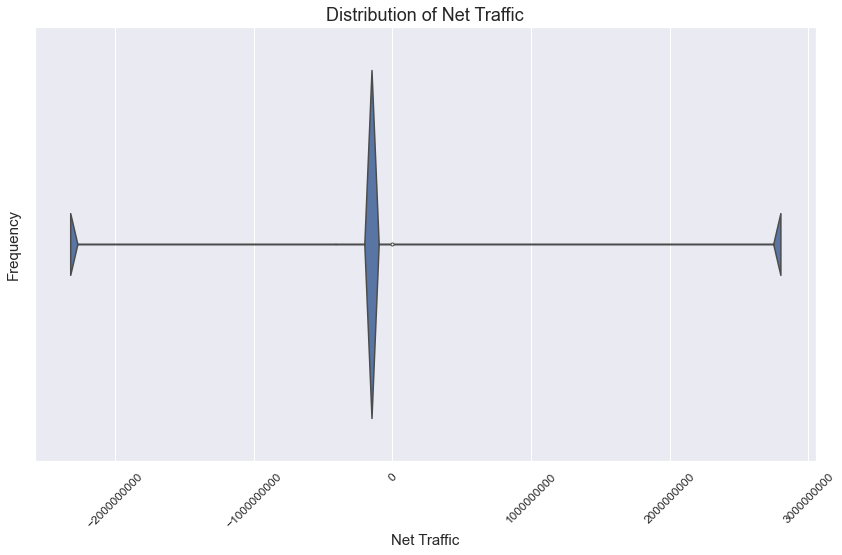

In [33]:
sns.set(rc={'figure.figsize':(14,8)})

sns.set_context('notebook')
sns.set_style('darkgrid')

g = sns.violinplot(x = MTA['Net Traffic'])
g.ticklabel_format(axis='x', style='plain')

g.set_title('Distribution of Net Traffic', fontsize = 18)
g.set_xlabel('Net Traffic', fontsize = 15)
g.set_ylabel('Frequency', fontsize = 15)

g.tick_params(axis='x', which='major', rotation = 45, labelsize = 12)
plt.show()

In [34]:
# Above plot clearly shows that there are abnormous outliers!

In [35]:
# Maximum turnstile passages should be calculated. Those values are generally for 4 hours.
# If we say at maximum 20 person can pass from a turnstile.
max_entry_exit = 20 * 60 * 4 
max_entry_exit
# Lets say 5000 is our upper value

4800

In [36]:
# So our values cannot be greater than 9600. Of course our values cannot be negative either.
df_impossible = MTA[(MTA['Net Entries'] < 0) | (MTA['Net Entries'] > 5000) | (MTA['Net Exits'] < 0) | (MTA['Net Exits'] > 5000)]
print('There are {} rows of information which cannot be true physically.'.format(len(df_impossible)))

There are 35198 rows of information which cannot be true physically.


In [37]:
percentage = len(df_impossible) * 100 / len(MTA)
print('%{} of our MTA data is problematic.'.format(round(percentage,2)))

%1.24 of our MTA data is problematic.


In [38]:
indexes = [*MTA.index.unique()]
list_ = []

for index in indexes :
    
    df = MTA[MTA.index == index]
    
    array_ent = np.array(df['Net Entries'])
    array_ext = np.array(df['Net Exits'])
        
    avg_ent = np.mean(array_ent[(array_ent >= 0) & (array_ent < 5000)])
    avg_ext = np.mean(array_ext[(array_ext >= 0) & (array_ext < 5000)])
    
    array_ent[(array_ent < 0) | (array_ent > 5000)] = avg_ent
    array_ext[(array_ext < 0) | (array_ext > 5000)] = avg_ext
    
    df['Net Entries'] = array_ent
    df['Net Exits'] = array_ext

    list_.append(df)   
    
MTA = pd.concat(list_, axis = 0)  

In [39]:
# Actually we only need the Net Traffic which is the sum of net entries and net exits. Since other 4 columns have no use
# from now on, I will drop them for simplicity.
MTA['Net Traffic'] = MTA['Net Entries'] + MTA['Net Exits']
MTA.drop(['Cumulative Entries','Cumulative Exits', 'Net Entries', 'Net Exits'], axis = 1, inplace = True)
MTA.head()

,Station,Hour,Day,Month,Date,Time Period,Borough,Coordinate,Net Traffic
Unique ID,,,,,,,,,
A002-R051-02-00-00,59_St,3,Tuesday,March,2022-03-01,12am - 4am,Brooklyn,"(40.641362, -74.017881)",0.0
A002-R051-02-00-00,59_St,7,Tuesday,March,2022-03-01,4am - 8am,Brooklyn,"(40.641362, -74.017881)",54.0
A002-R051-02-00-00,59_St,11,Tuesday,March,2022-03-01,8am - 12pm,Brooklyn,"(40.641362, -74.017881)",336.0
A002-R051-02-00-00,59_St,15,Tuesday,March,2022-03-01,12pm - 4pm,Brooklyn,"(40.641362, -74.017881)",144.0
A002-R051-02-00-00,59_St,19,Tuesday,March,2022-03-01,4pm - 8pm,Brooklyn,"(40.641362, -74.017881)",273.0


In [40]:
MTA['Net Traffic'].describe()

count    2.839340e+06
mean     1.661749e+02
std      2.072345e+02
min      0.000000e+00
25%      1.700000e+01
50%      9.300000e+01
75%      2.410000e+02
max      7.107000e+03
Name: Net Traffic, dtype: float64

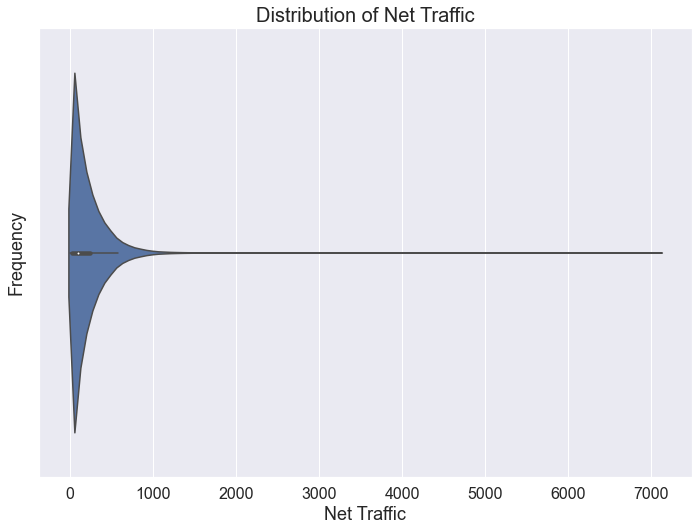

In [41]:
sns.set_style('whitegrid')
sns.set(rc={'figure.figsize':(11.7,8.27)})

b = sns.violinplot(x = MTA['Net Traffic'])
plt.ticklabel_format(axis='x', style='plain')

b.set_xlabel('Net Traffic', fontsize = 18)
b.set_ylabel('Frequency', fontsize = 18)
b.set_title('Distribution of Net Traffic', fontsize = 20)

plt.tick_params(axis='both', which='major', labelsize=16)

plt.show()

In [42]:
# Those outliers can be due to various reasons, after our manipılation process, those outliers wont be affecting the
# result significantly, however it is not safe to eliminate all because some of those outliers might be real datas due to
# some event or something.

In [43]:
# In my study I examined 4 months of data, lets look at it month by month to see if there is a pattern about busy stations.

In [44]:
total_traffic = MTA.groupby('Station')['Net Traffic'].sum().sort_values(ascending = False).reset_index()
total_traffic_top_10 = total_traffic.head(10)
total_traffic_top_10

,Station,Net Traffic
0,34_St_Penn_Sta,1.417943e+07
1,Grd_Cntrl_42_St,1.143390e+07
2,34_St_Herald_Sq,1.047817e+07
3,86_St,9.188758e+06
4,14_St_Union_Sq,9.179920e+06
5,Times_Sq_42_St,8.941712e+06
6,23_St,8.934557e+06
7,42_St_Port_Auth,8.458569e+06
8,Fulton_St,7.851576e+06
9,125_St,7.780267e+06


In [45]:
average_traffic = MTA.groupby(['Station','Date']).agg({'Net Traffic': 'sum'})
average_traffic = average_traffic.groupby('Station')['Net Traffic']\
                                                    .mean().reset_index().sort_values('Net Traffic', ascending =False)
average_traffic_top_10 = average_traffic.head(10)
average_traffic_top_10

,Station,Net Traffic
57,34_St_Penn_Sta,130086.554022
216,Grd_Cntrl_42_St,104898.128440
55,34_St_Herald_Sq,96129.978017
104,86_St,84300.534814
15,14_St_Union_Sq,84219.451195
310,Times_Sq_42_St,82034.055046
47,23_St,81968.412844
66,42_St_Port_Auth,77601.547372
209,Fulton_St,72032.808894
8,125_St,71378.596105


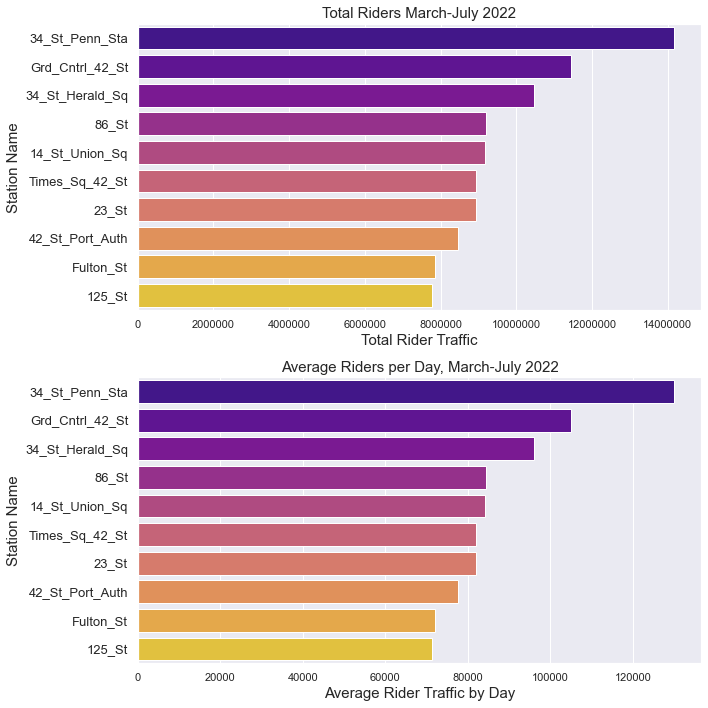

In [46]:
sns.set_style('darkgrid')
fig, axes = plt.subplots(2,1, figsize = (10,10))

chart = sns.barplot(data = total_traffic_top_10, x = 'Net Traffic', y = 'Station', ax = axes[0], palette = 'plasma')
chart.set_yticklabels(chart.get_ymajorticklabels(), fontsize = 13)

chart.set_ylabel('Station Name', fontsize=15)
chart.set_xlabel('Total Rider Traffic', fontsize=15)
chart.set_title('Total Riders March-July 2022', fontsize=15)
chart.ticklabel_format(axis='x', style='plain')

chart2 = sns.barplot(data = average_traffic_top_10, x = 'Net Traffic', y = 'Station', ax = axes[1], palette = 'plasma')
chart2.set_yticklabels(chart2.get_ymajorticklabels(), fontsize = 13)

chart2.set_ylabel('Station Name', fontsize = 15)
chart2.set_xlabel('Average Rider Traffic by Day', fontsize=15)
chart2.set_title('Average Riders per Day, March-July 2022', fontsize=15)

plt.tight_layout()
plt.savefig(fname = 'top10 riders darkgrid', bbox_inches = 'tight')
plt.show()

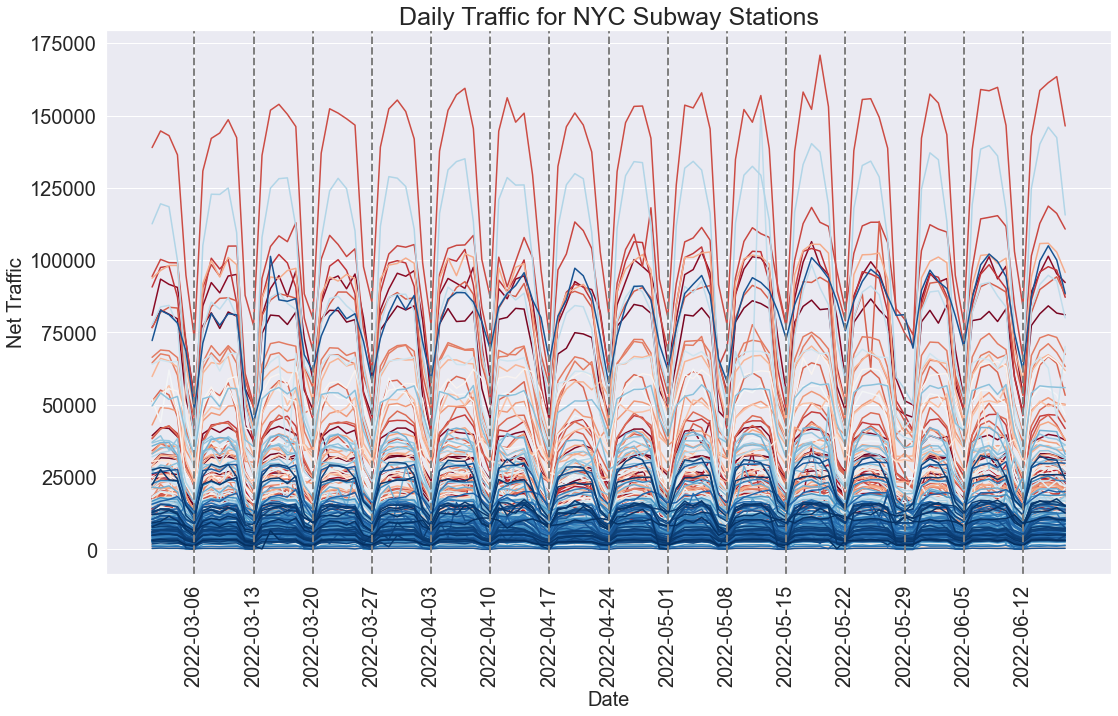

In [47]:
daily_traffic = MTA.groupby(['Station', 'Date'])['Net Traffic'].sum().reset_index()

fig, axes = plt.subplots(figsize = (18,10))
    
p = sns.lineplot(data = daily_traffic, x = 'Date', y = 'Net Traffic', hue = 'Station', legend = False, palette = 'RdBu')

x_ticks = list(MTA['Date'].unique())[5::7]
p.set_xticks(x_ticks)
p.set_xticklabels(labels = x_ticks, rotation = 90)

p.set_xlabel('Date', fontsize = 20)
p.set_ylabel('Net Traffic', fontsize = 20)
p.set_title('Daily Traffic for NYC Subway Stations', fontsize = 25)


for tick in x_ticks:
    plt.axvline(x = tick, linewidth = 2, linestyle = '--', color = 'gray')
    
plt.tick_params(axis='both', which='major', labelsize = 20) 
   
plt.show()

In [48]:
heatmap_dataset = MTA.groupby(['Station','Day', 'Time Period'])['Net Traffic'].sum().reset_index()
heatmap_dataset.head()

,Station,Day,Time Period,Net Traffic
0,103_St,Monday,12am - 4am,26807.0
1,103_St,Monday,4am - 8am,8703.0
2,103_St,Monday,8am - 12pm,96755.0
3,103_St,Monday,12pm - 4pm,83500.0
4,103_St,Monday,4pm - 8pm,119447.0


In [49]:
heatmap_stations = [*total_traffic_top_10['Station']]
heatmap_stations

['34_St_Penn_Sta',
 'Grd_Cntrl_42_St',
 '34_St_Herald_Sq',
 '86_St',
 '14_St_Union_Sq',
 'Times_Sq_42_St',
 '23_St',
 '42_St_Port_Auth',
 'Fulton_St',
 '125_St']

C:\Users\onury\AppData\Local\Temp\ipykernel_9840\2329114390.py:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar_ax.set_yticklabels(ticklabs, fontsize=15, **tick_font)


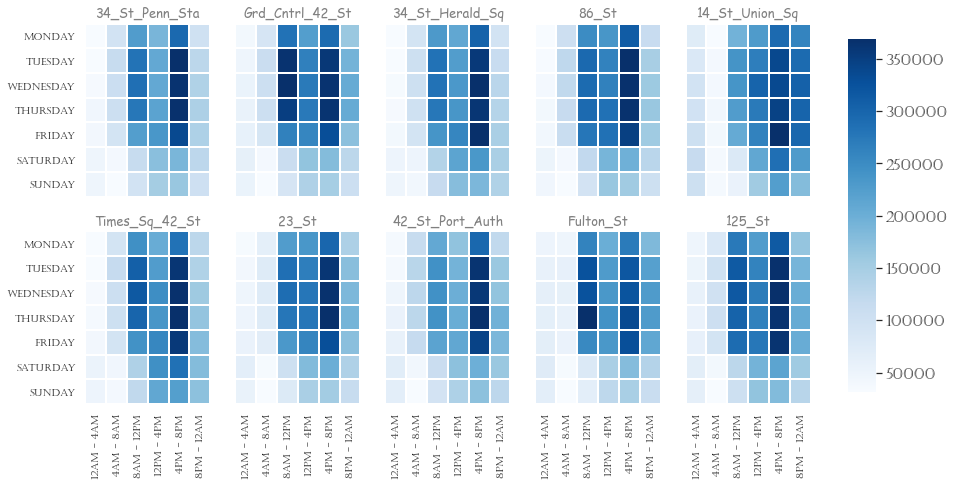

In [50]:
title_font = {'fontname':'Comic Sans MS'}
tick_font = {'fontname': 'Castellar'}

fig, axes = plt.subplots(2, 5, figsize = (13,7), sharex = True, sharey = True)
station_number = 0
cbar_ax = fig.add_axes([0.94, 0.15, 0.03, 0.7])

for i in range(2): #Rows
    
    for j in range(5): #Columns
        
        copy = heatmap_dataset.copy()
        copy.set_index('Station', inplace = True)
        copy1 = copy[copy.index == heatmap_stations[station_number]]
        copy2 = copy1.pivot_table(index = 'Day', columns = 'Time Period', values = 'Net Traffic')
        
        xticks = copy1['Time Period'].unique()
        yticks = copy1['Day'].unique()
        
        hm = sns.heatmap(copy2, ax = axes[i][j], linewidths = 1.6, cmap = 'Blues', cbar_ax = cbar_ax)
        hm.set_xlabel('')
        hm.set_ylabel('')
        hm.set_title(heatmap_stations[station_number], fontsize = 13 , color = 'gray',  **title_font)
        
        hm.set_xticklabels(xticks, fontsize = 10, **tick_font, color = 'black')
        hm.set_yticklabels(yticks, fontsize = 10, **tick_font, color = 'black')
        
        station_number += 1
        

ticklabs = cbar_ax.get_yticklabels()
cbar_ax.set_yticklabels(ticklabs, fontsize=15, **tick_font)

plt.show()

In [51]:
MTA.head()

,Station,Hour,Day,Month,Date,Time Period,Borough,Coordinate,Net Traffic
Unique ID,,,,,,,,,
A002-R051-02-00-00,59_St,3,Tuesday,March,2022-03-01,12am - 4am,Brooklyn,"(40.641362, -74.017881)",0.0
A002-R051-02-00-00,59_St,7,Tuesday,March,2022-03-01,4am - 8am,Brooklyn,"(40.641362, -74.017881)",54.0
A002-R051-02-00-00,59_St,11,Tuesday,March,2022-03-01,8am - 12pm,Brooklyn,"(40.641362, -74.017881)",336.0
A002-R051-02-00-00,59_St,15,Tuesday,March,2022-03-01,12pm - 4pm,Brooklyn,"(40.641362, -74.017881)",144.0
A002-R051-02-00-00,59_St,19,Tuesday,March,2022-03-01,4pm - 8pm,Brooklyn,"(40.641362, -74.017881)",273.0


In [52]:
top10_daily = MTA[MTA['Station'].isin(heatmap_stations)].\
              groupby(['Station','Time Period', 'Date'])['Net Traffic'].sum().reset_index()
top10_daily = top10_daily.groupby(['Station', 'Time Period'])['Net Traffic'].mean().reset_index()
top10_daily.head()

,Station,Time Period,Net Traffic
0,125_St,12am - 4am,3699.045872
1,125_St,4am - 8am,5056.467890
2,125_St,8am - 12pm,15898.573046
3,125_St,12pm - 4pm,15247.445077
4,125_St,4pm - 8pm,19957.449541


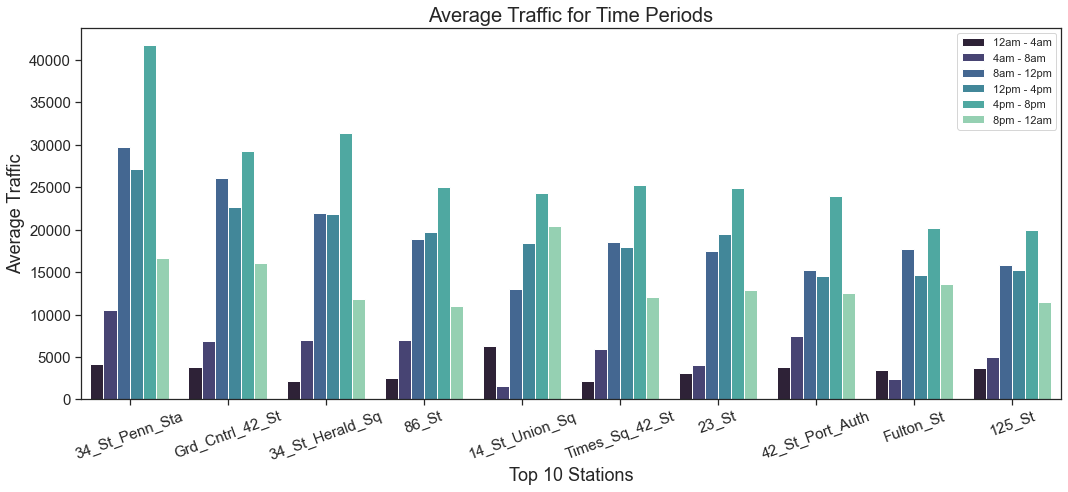

In [53]:
sns.set_style('ticks')

fig, ax = plt.subplots(figsize = (15,7))
barplot = sns.barplot(data = top10_daily, x = 'Station', y = 'Net Traffic', hue = 'Time Period',\
                      palette = 'mako', order = heatmap_stations)
barplot.tick_params(axis = 'both', labelsize = 15)
barplot.tick_params(axis = 'x', rotation = 20)
barplot.set_xlabel('Top 10 Stations', fontsize = 18)
barplot.set_ylabel('Average Traffic', fontsize = 18)
barplot.set_title('Average Traffic for Time Periods', fontsize = 20)
plt.tight_layout()
ax.legend(loc = 'best')
plt.show()

In [54]:
childcares = pd.read_csv('Childcare_Locations.csv')
schools = pd.read_csv('School_Locations.csv')

In [55]:
childcares['Facility Status'].unique()

array(['Registration', 'License', 'Pending Revocation',
       'Pending Revocation and Denial', 'Suspended'], dtype=object)

In [56]:
childcares['Region Code'].unique()

array(['SRO', 'YRO', 'LIRO', 'ARO', 'NYCDOH', 'RRO', 'BRO'], dtype=object)

In [57]:
childcares = childcares[(childcares['Region Code'] == 'NYCDOH')]
childcares = childcares[childcares['Facility Status'].isin(['Registration', 'License'])]
childcares = childcares.loc[:,['Facility Name', 'Latitude', 'Longitude']]
childcares.dropna(axis = 0, inplace = True)
childcares.reset_index(drop = True, inplace = True)
childcares['Coordinate'] = list(zip(childcares.Latitude, childcares.Longitude))
childcares.drop(['Latitude', 'Longitude'], axis = 1, inplace = True)
childcares.drop_duplicates(subset = ['Facility Name'], keep = 'first', inplace = True)
childcares.head()

,Facility Name,Coordinate
0,"Adorno, Olga","(40.840315, -73.913785)"
1,"Ahmed, Fatema","(40.853095, -73.861309)"
2,Beansprouts,"(40.668804, -73.983502)"
3,SCAN-Harbor,"(40.836126, -73.904558)"
4,"Colon, Maria","(40.686403, -73.877452)"


In [58]:
childcares.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6724 entries, 0 to 7103
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Facility Name  6724 non-null   object
 1   Coordinate     6724 non-null   object
dtypes: object(2)
memory usage: 157.6+ KB


In [59]:
schools['Location_Category_Description'].unique()

array(['Elementary', 'Junior High-Intermediate-Middle', 'K-8',
       'K-12 all grades', 'Secondary School', 'High school',
       'Early Childhood', 'Ungraded', 'Collaborative or Multi-graded'],
      dtype=object)

In [60]:
schools['Status_descriptions'].unique()

array(['Open', 'Closed', 'Initiated, never opened'], dtype=object)

In [61]:
schools = schools[schools['Location_Category_Description'].isin(['Early Childhood', 'Elementary'])]
schools = schools[schools['Status_descriptions'] == 'Open']
schools = schools.loc[:,['location_name', 'LATITUDE', 'LONGITUDE']]
schools.dropna(axis = 0, inplace = True)
schools.reset_index(drop = True, inplace = True)
schools['Coordinate'] = list(zip(schools.LATITUDE, schools.LONGITUDE))
schools.drop(['LATITUDE', 'LONGITUDE'], axis = 1, inplace = True)
schools.drop_duplicates(subset = ['location_name'], inplace = True)
schools.rename(columns = {'location_name': 'Facility Name'}, inplace = True)
schools.head()

,Facility Name,Coordinate
0,P.S. 001 The Bergen,"(40.648959, -74.01142)"
1,P.S. 003 The Bedford Village,"(40.682311, -73.955219)"
2,P.S. K004,"(40.6585, -73.879276)"
3,P.S. 005 Dr. Ronald McNair,"(40.685241, -73.92197)"
4,Norma Adams Clemons Academy,"(40.648973, -73.956279)"


In [62]:
schools.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 746 entries, 0 to 767
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Facility Name  746 non-null    object
 1   Coordinate     746 non-null    object
dtypes: object(2)
memory usage: 17.5+ KB


In [63]:
MTA_locations = MTA[['Station','Coordinate']]
MTA_locations.drop_duplicates(subset = ['Station'], keep = 'first', inplace = True)
MTA_locations.reset_index(inplace = True, drop = True)
MTA_locations.head()

,Station,Coordinate
0,59_St,"(40.641362, -74.017881)"
1,5_Av_59_St,"(40.764811, -73.973347)"
2,57_St_7_Av,"(40.764664, -73.980658)"
3,Times_Sq_42_St,"(40.754672, -73.986754)"
4,34_St_Herald_Sq,"(40.749567, -73.98795)"


In [64]:
childcares_schools = pd.concat([childcares, schools], axis = 0, ignore_index = True)
print(len(childcares_schools))
childcares_schools.head()

7470


,Facility Name,Coordinate
0,"Adorno, Olga","(40.840315, -73.913785)"
1,"Ahmed, Fatema","(40.853095, -73.861309)"
2,Beansprouts,"(40.668804, -73.983502)"
3,SCAN-Harbor,"(40.836126, -73.904558)"
4,"Colon, Maria","(40.686403, -73.877452)"


In [65]:
dict_list = []

for index, row in MTA_locations.iterrows():
    for i in range(len(childcares_schools)):
        
        Distance = distance.distance(row['Coordinate'], childcares_schools.loc[i, 'Coordinate']).km
        
        dict = {'Station': row['Station'],
                'Facility Name': childcares_schools.loc[i, 'Facility Name'],
                'Distance': Distance}                
        
        dict_list.append(dict)
        
distance_df = pd.DataFrame(dict_list)

In [66]:
distance_df.head()

,Station,Facility Name,Distance
0,59_St,"Adorno, Olga",23.778740
1,59_St,"Ahmed, Fatema",26.976045
2,59_St,Beansprouts,4.211888
3,59_St,SCAN-Harbor,23.651789
4,59_St,"Colon, Maria",12.885207


In [67]:
stations_close_schools_childcares = distance_df[distance_df['Distance'] < 0.500].\
                                    groupby('Station')['Distance'].size().sort_values(ascending = False).reset_index().head(10)

station_list = [*stations_close_schools_childcares['Station']]

print(station_list)
stations_close_schools_childcares.rename(columns = {'Distance': 'Nearby Facilities'}, inplace = True)

close_stations_traffic = average_traffic[average_traffic['Station'].isin(station_list)]

close_stations = stations_close_schools_childcares.merge(close_stations_traffic, how = 'left', on = 'Station')
close_stations = close_stations.merge(MTA_locations, how='left', on = 'Station')

close_stations

['182_183_Sts', '167_St', '170_St', '183_St', 'Mt_Eden_Av', 'Fordham_Rd', 'Burnside_Av', '174_175_Sts', 'Kingsbridge_Rd', '176_St']


,Station,Nearby Facilities,Net Traffic,Coordinate
0,182_183_Sts,131,2608.339450,"(40.856093, -73.900741)"
1,167_St,129,16308.788991,"(40.833771, -73.91844)"
2,170_St,128,13673.027523,"(40.839306, -73.9134)"
3,183_St,114,5077.192661,"(40.858407, -73.903879)"
4,Mt_Eden_Av,110,4696.321101,"(40.844434, -73.914685)"
5,Fordham_Rd,109,15160.045872,"(40.861296, -73.897749)"
6,Burnside_Av,103,8073.100917,"(40.853453, -73.907684)"
7,174_175_Sts,103,3759.642202,"(40.8459, -73.910136)"
8,Kingsbridge_Rd,95,14104.753410,"(40.866978, -73.893509)"
9,176_St,93,5053.302752,"(40.84848, -73.911794)"


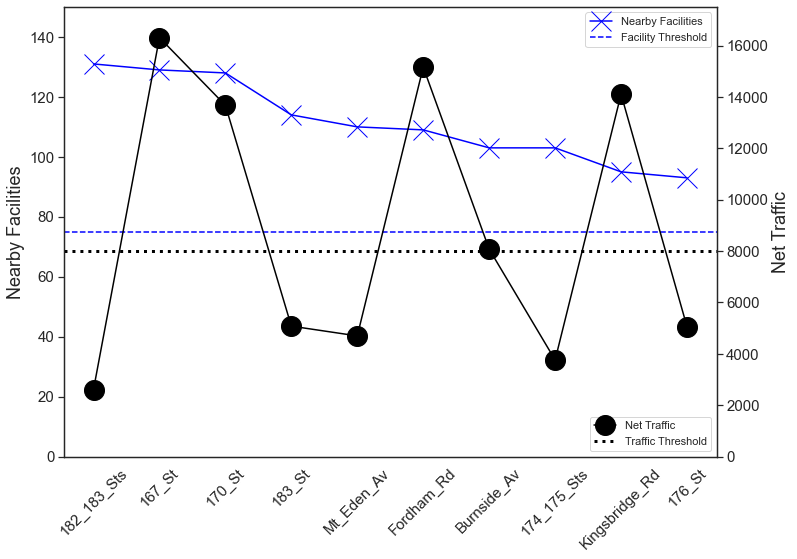

In [69]:
sns.set_style('white')
fig ,ax = plt.subplots()

ax.plot(close_stations['Station'], close_stations['Nearby Facilities'], color = 'blue', marker = 'x',\
        markersize = 20, label = 'Nearby Facilities')

ax.set_ylim(0,150)
ax.set_ylabel('Nearby Facilities', fontsize = 18)
ax.axhline(75, linestyle = '--', label = 'Facility Threshold', color = 'blue')

ax2 = ax.twinx()

ax2.plot(close_stations['Station'], close_stations['Net Traffic'], color = 'black', marker = 'o',\
         markersize = 20, label = 'Net Traffic')
ax.tick_params(axis = 'x', labelsize = 15, rotation = 45)
ax.tick_params(axis = 'y', labelsize = 15)

ax2.set_ylim(0,17500)
ax2.set_ylabel('Net Traffic', fontsize = 18)
ax2.axhline(8000, linestyle = ':', label = 'Traffic Threshold', color = 'black', linewidth = 3)
ax2.tick_params(axis = 'both', labelsize = 15)

ax.legend(loc = 'best')
ax2.legend(loc = 'lower right')

plt.show()

In [70]:
stations_needed = close_stations[(close_stations['Nearby Facilities'] > 70) & (close_stations['Net Traffic'] > 8000)]
stations_needed.reset_index(drop = True, inplace = True)
stations_needed

,Station,Nearby Facilities,Net Traffic,Coordinate
0,167_St,129,16308.788991,"(40.833771, -73.91844)"
1,170_St,128,13673.027523,"(40.839306, -73.9134)"
2,Fordham_Rd,109,15160.045872,"(40.861296, -73.897749)"
3,Burnside_Av,103,8073.100917,"(40.853453, -73.907684)"
4,Kingsbridge_Rd,95,14104.753410,"(40.866978, -73.893509)"


In [79]:
only_station_list = distance_df[distance_df['Station'].isin([*stations_needed['Station']])]
only_station_list = only_station_list[only_station_list['Distance'] < 0.500]['Facility Name'].unique()
childcares_schools_needed = childcares_schools[childcares_schools['Facility Name'].isin(only_station_list)]
childcares_schools_needed.reset_index(drop = True, inplace = True)
childcares_schools_needed

,Facility Name,Coordinate
0,"Adorno, Olga","(40.840315, -73.913785)"
1,"Perez, Andrea","(40.842958, -73.914431)"
2,"Batista, Gladys","(40.83217, -73.921307)"
3,"Feliz, Mabel","(40.838491, -73.914969)"
4,"Aguiar, Dulce","(40.837625, -73.918668)"
...,...,...
518,The Family School,"(40.831873, -73.917526)"
519,Sheridan Academy for Young Leaders,"(40.831873, -73.917526)"
520,Rosalyn Yalow Charter School,"(40.836679, -73.91735)"
521,Mount Eden Children's Academy,"(40.842503, -73.916084)"


In [71]:
stations_needed_list = [*stations_needed['Station']]
stations_needed_traffic = MTA[MTA['Station'].isin(stations_needed_list)]
stations_needed_traffic = stations_needed_traffic.groupby(['Station','Day','Hour'])['Net Traffic'].sum().reset_index()
stations_needed_traffic

,Station,Day,Hour,Net Traffic
0,167_St,Monday,0,20388.0
1,167_St,Monday,1,0.0
2,167_St,Monday,3,662.0
3,167_St,Monday,4,6180.0
4,167_St,Monday,5,0.0
...,...,...,...,...
695,Kingsbridge_Rd,Sunday,19,0.0
696,Kingsbridge_Rd,Sunday,20,1713.0
697,Kingsbridge_Rd,Sunday,21,22214.0
698,Kingsbridge_Rd,Sunday,22,0.0


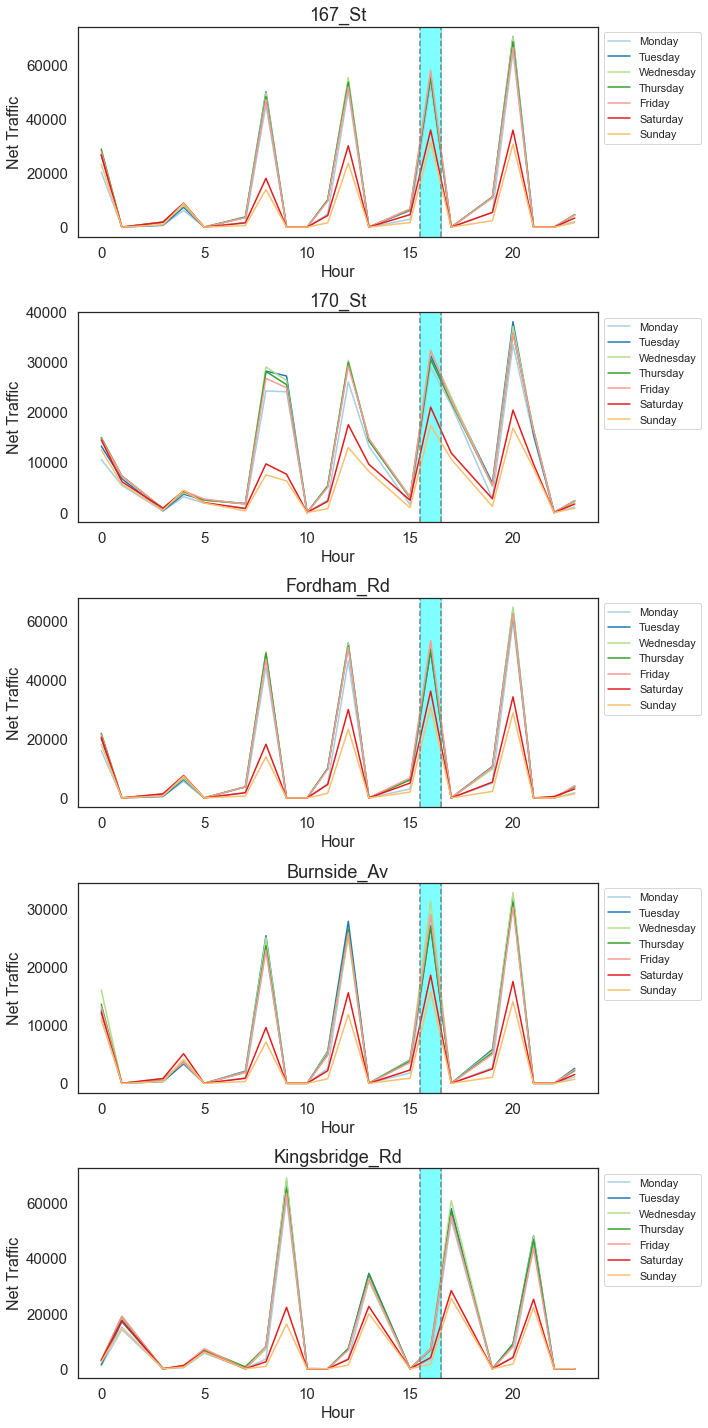

In [72]:
fig, ax = plt.subplots(5,1, figsize = (10,20))

for i in range(5):
    df_lineplot = stations_needed_traffic[stations_needed_traffic['Station'] == stations_needed_list[i]]
    sns.lineplot(data = df_lineplot, x = 'Hour', y = 'Net Traffic', hue = 'Day', palette = 'Paired', ax = ax[i])
    ax[i].set_xlabel('Hour', fontsize = 16)
    ax[i].set_ylabel('Net Traffic', fontsize = 16)
    ax[i].set_title(stations_needed_list[i], fontsize = 18)
    ax[i].axvline(15.5, linestyle = '--', linewidth = 1.5, color = 'gray')
    ax[i].axvline(16.5, linestyle = '--', linewidth = 1.5, color = 'gray')
    ax[i].axvspan(15.5, 16.5, alpha=0.5, color='cyan')
    ax[i].tick_params(axis = 'both', labelsize = 15)
    ax[i].legend(bbox_to_anchor = (1,1))

plt.tight_layout()

In [73]:
top10 = total_traffic_top_10.merge(MTA_locations, how = 'left', on = 'Station')
top10

,Station,Net Traffic,Coordinate
0,34_St_Penn_Sta,1.417943e+07,"(40.752287, -73.993391)"
1,Grd_Cntrl_42_St,1.143390e+07,"(40.751776, -73.976848)"
2,34_St_Herald_Sq,1.047817e+07,"(40.749567, -73.98795)"
3,86_St,9.188758e+06,"(40.622687, -74.028398)"
4,14_St_Union_Sq,9.179920e+06,"(40.735736, -73.990568)"
5,Times_Sq_42_St,8.941712e+06,"(40.754672, -73.986754)"
6,23_St,8.934557e+06,"(40.741303, -73.989344)"
7,42_St_Port_Auth,8.458569e+06,"(40.757308, -73.989735)"
8,Fulton_St,7.851576e+06,"(40.710374, -74.007582)"
9,125_St,7.780267e+06,"(40.811109, -73.952343)"


In [80]:
flipped_coords_stations_needed = []
flipped_coords_childcares_schools = []
flipped_coords_top10 = []

for i in range(len(stations_needed)):
    flipped_coords_stations_needed.append(stations_needed.loc[i,'Coordinate'][::-1])
    
for j in range(len(childcares_schools_needed)):
    flipped_coords_childcares_schools.append(childcares_schools_needed.loc[j,'Coordinate'][::-1])

for k in range(len(top10)):
    flipped_coords_top10.append(top10.loc[k,'Coordinate'][::-1])
    
stations_needed['Flipped Coordinates'] = flipped_coords_stations_needed
childcares_schools_needed['Flipped Coordinates'] = flipped_coords_childcares_schools
top10['Flipped Coordinates'] = flipped_coords_top10

stations_needed['GeoData'] = [Point(xy) for (xy) in stations_needed['Flipped Coordinates']]
childcares_schools_needed['GeoData'] = [Point(xy) for (xy) in childcares_schools_needed['Flipped Coordinates']]
top10['GeoData'] = [Point(xy) for (xy) in top10['Flipped Coordinates']]

stations_needed.head()

,Station,Nearby Facilities,Net Traffic,Coordinate,Flipped Coordinates,GeoData
0,167_St,129,16308.788991,"(40.833771, -73.91844)","(-73.91844, 40.833771)",POINT (-73.91844 40.833771)
1,170_St,128,13673.027523,"(40.839306, -73.9134)","(-73.9134, 40.839306)",POINT (-73.9134 40.839306)
2,Fordham_Rd,109,15160.045872,"(40.861296, -73.897749)","(-73.897749, 40.861296)",POINT (-73.897749 40.861296)
3,Burnside_Av,103,8073.100917,"(40.853453, -73.907684)","(-73.907684, 40.853453)",POINT (-73.907684 40.853453)
4,Kingsbridge_Rd,95,14104.753410,"(40.866978, -73.893509)","(-73.893509, 40.866978)",POINT (-73.893509 40.866978)


In [81]:
stations_to_gdf = gpd.GeoDataFrame(stations_needed, geometry = 'GeoData')
childcares_schools_to_gdf = gpd.GeoDataFrame(childcares_schools_needed, geometry = 'GeoData')
top10_to_gdf = gpd.GeoDataFrame(top10, geometry = 'GeoData')

In [76]:
nyc_map = gpd.read_file('C:/Users/onury/OneDrive/Belgeler/ny_shape_files/geo_export_c088c4c0-12f1-41b1-ba81-5e12dd36385a.shp')
nyc_map.geometry = nyc_map.geometry.set_crs(epsg=4326, allow_override=True)

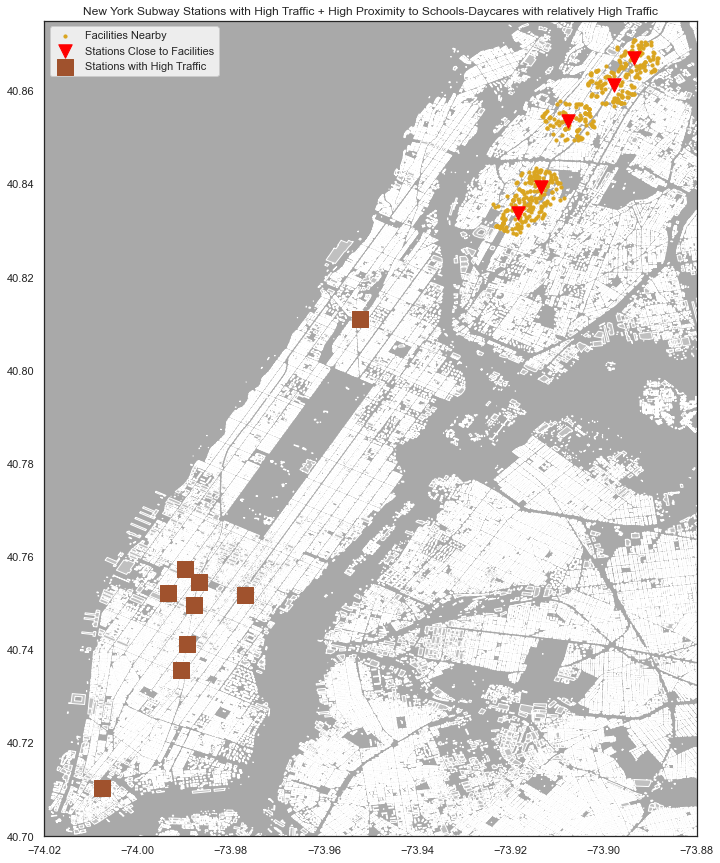

In [84]:
fig, ax = plt.subplots(figsize = (15,15))
nyc_map.plot(ax = ax, color = 'silver')

ax.set_xlim(left = -74.02, right = -73.88)
ax.set_ylim(bottom = 40.70, top = 40.875)
ax.set_title('New York Subway Stations with High Traffic + High Proximity to Schools-Daycares with relatively High Traffic')
ax.set_facecolor('darkgrey')

childcares_schools_to_gdf.plot(ax = ax, markersize=10, color="goldenrod", marker="o", label="Facilities Nearby")
stations_to_gdf.plot(ax = ax, markersize=180, color="red", marker="v", label="Stations Close to Facilities")
top10_to_gdf.plot(ax = ax, markersize = 250, color = 'sienna', marker = 's', label = 'Stations with High Traffic')

ax.legend()
plt.savefig('ny map correctedx', bbox_inches = 'tight')
plt.show()